In [1]:
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
from experiments import run_experiments

# The Data
## Log-Normal Distribution
In order to simulate an annoying real-world distribution, I used the log-normal distribution and rounded the results

This causes a large number of uniques, but with heavy-hitters and several lower probability uniques that still show up several times

## Sample Random Seed
To generate the same sample on several runs, I just used my id as the random seed.

## Sample size
I choose to use a million (1e6) samples, since it's a nice round number.


In [3]:
X = lognorm.rvs(5, size=int(1e6), random_state=206783441).astype(int)

## Number of unique values
With the chosen seed I got 37418 unique values - which is matches the criteria

In [4]:
np.unique(X).shape

(37418,)

## How the distributions looks
We can see what I mean - many heavy hitters close to 0, but plenty of uniques

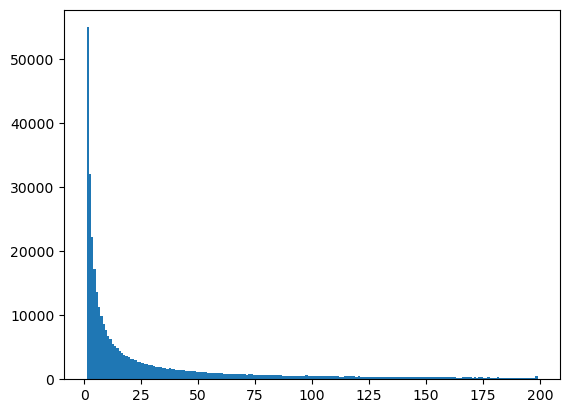

In [5]:
plt.hist(X, bins=np.arange(1, 200))
plt.show()

# Experiments
## Parameters
I ran 100 different experiments for each estimator and config, with the seeds being the values 1 to 100 for each one.

I used the seed to init the random hash function (the way it works is further elaborated in the file `experiments.py`) and besides that everthing else is deterministic

## Single $\alpha$ estimator
Here I ran a full FM estimator with a single hash function and a single $\beta$ estimator - which is just an $\alpha$ estimator

In [6]:
alpha_results = run_experiments(X, base_seeds=np.arange(1, 101).tolist(), num_hashes=1, num_betas=1, num_procs=7)

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


### The results
We can already see that median is really far from the actual value (around twice!)

In [7]:
np.median(alpha_results)

np.float64(201309.8023417926)

The mean is even worse, most likely due to outliers (as we'll see later)

In [8]:
np.mean(alpha_results)

np.float64(421458.64660335844)

The normalized variance is also insane - it's more than 2.9 million

In [9]:
np.var(alpha_results) / len(np.unique(X))

np.float64(53393774.54462497)

when we plot a histogram of the values with the actual number of uniques, the mean, and the median - we can see that they are not even close!

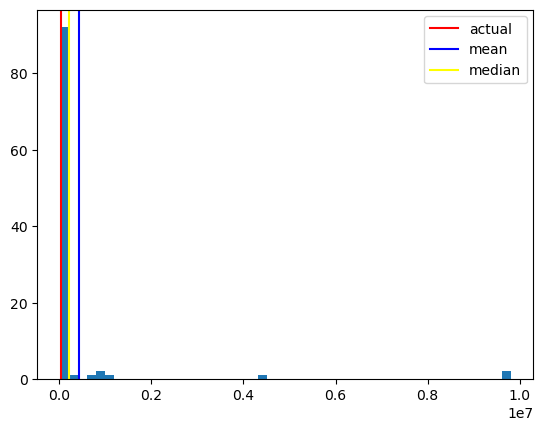

In [34]:
plt.hist(alpha_results, bins=50)
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(alpha_results), color='blue', label='mean')
plt.axvline(x=np.median(alpha_results), color='yellow', label='median')
plt.legend()
plt.show()

If we zoom in a bit, we can see that the median has most values around it, while the actual value is the **15th percentile!**

In [53]:
np.mean(np.array(alpha_results) <= len(np.unique(X)))

np.float64(0.15)

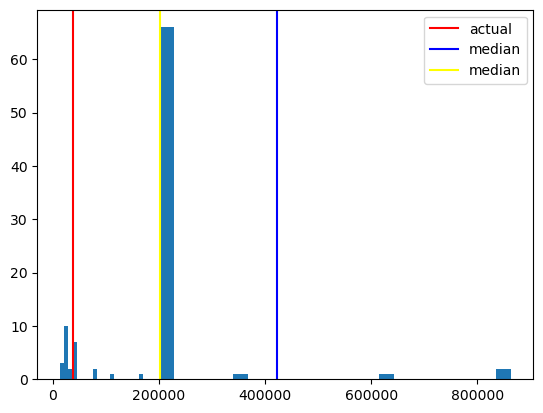

In [50]:
bins = np.linspace(np.min(alpha_results), np.percentile(alpha_results, 75), 25).tolist() + \
       np.linspace(np.percentile(alpha_results, 75), np.percentile(alpha_results, 95), 25).tolist()
plt.hist(alpha_results, bins=sorted(bins))
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(alpha_results), color='blue', label='median')
plt.axvline(x=np.median(alpha_results), color='yellow', label='median')
plt.legend()
plt.show()

this shows that as we learned at class, the $\alpha$ estimator has way too much variance to be used as is

## Single $\beta$ estimator
Here I ran a full FM estimator with a several hash functions and a single $\beta$ estimator - which is just a $\beta$ estimator

### Evaluated sketch sizes
For the beta estimator, I ran the same number of experiments with the following sketch sizes: $k = [10, 50, 100, 500]$

In [11]:
beta_sketch_sizes = [10, 50, 100, 500]

### Other Parameters
Due to the computation times, here I just ran 50 experiments for each sketch size - for the larger sketch sizes it took quite a while

In [12]:
beta_results = {
    sketch_size: run_experiments(X, base_seeds=np.arange(1, 51).tolist(), num_hashes=sketch_size, num_betas=1, num_procs=7)
    for sketch_size in beta_sketch_sizes
}

100%|██████████| 50/50 [1:04:00<00:00, 76.80s/it] 


In [19]:
import pickle
with open('beta_results.pkl', 'wb') as f:
    pickle.dump(beta_results, f)

In [13]:
# tmp_results = run_experiments(X, base_seeds=np.arange(1, 101).tolist(), num_hashes=10, num_betas=1, num_procs=8)
tmp_results = beta_results[10]

In [14]:
np.median(tmp_results)

np.float64(97718.11388261715)

In [15]:
np.mean(tmp_results)

np.float64(105683.21876276238)

In [16]:
np.var(tmp_results) / len(np.unique(X))

np.float64(73114.22657305066)

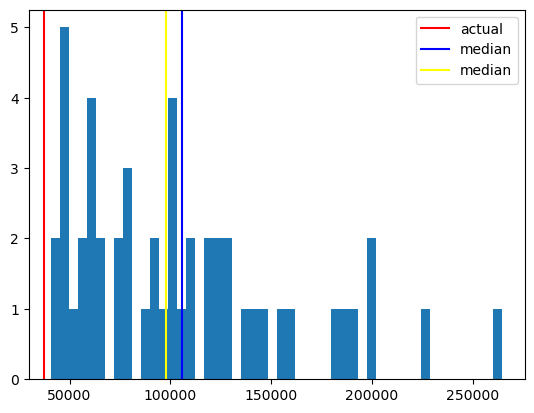

In [17]:
plt.hist(tmp_results, bins=50)
plt.axvline(x=len(np.unique(X)), color='red', label='actual')
plt.axvline(x=np.mean(tmp_results), color='blue', label='median')
plt.axvline(x=np.median(tmp_results), color='yellow', label='median')
plt.legend()
plt.show()